# Describing the Provided Solver: `DenseDomain`

This notebook provides an overview on the provided `DenseDomain` solver.

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from _plot_domain import plot_dense_domain

from parallel_heat.domain import DenseDomain, ProblemParamaters, Side


## `DenseDomain`

The `DenseDomain` stores an array of values in $x$ and $y$, with spacing provided in the `parameters` property. Each domain has a grid of interior values somewhere in space, indexed by integer values.

Setting field u(x,y) = x:


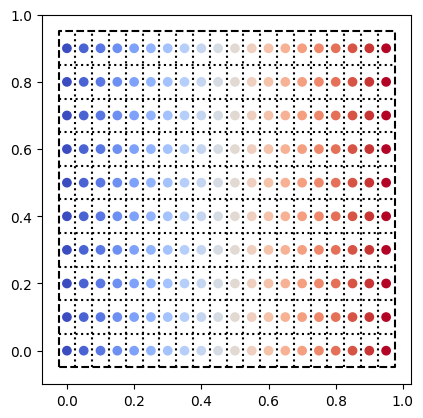

In [17]:
nx = 20
nz = 10
domain = DenseDomain(
    nx,
    nz,
    parameters=ProblemParamaters(dx=0.05, dy=0.1, dt=0.001, diffusivity=0.5),
)

print("Setting field u(x,y) = x:")
domain.field[...] = np.linspace(0, domain.width, nx)[:, np.newaxis]
plot_dense_domain(domain, include_ghost_cells=False)
plt.show()

Solving the heat equation is handled by the `update` method, which takes the field at some time $t$, and updates it to time $t + \verb+dt+$, with `dt` given in the parameters.

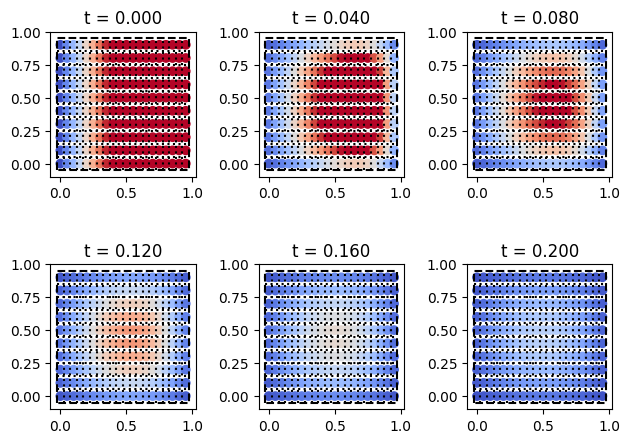

In [18]:
# reset field to u(x) = x
domain.field[...] = np.linspace(0, domain.width, nx)[:, np.newaxis]

fig, axs = plt.subplots(nrows=2, ncols=3)
t = 0
for ax in axs.flatten():
    # -=-   plot   -=-
    plt.sca(ax)
    plot_dense_domain(domain, vmin=0, vmax=0.4, include_ghost_cells=False)
    plt.title(f"t = {t:.3f}")
    # -=- end plot -=-

    for _ in range(40):
        # -=-   update   -=-
        t += domain.parameters.dt
        domain.step()
        # -=- end update -=-

fig.tight_layout()
plt.show()

### Ghost Cells

When we decompose a domain, we need some way of communicating the adjacent values across different grids. In this assignment, we do this by providing the adjacent values into "ghost cells".
Recall the update equation:

$$u^{(k+1)}_{i,j} =u^{(k)}_{i,j} + D(\Delta t)\left(\frac{u^{(k)}_{i-1,j} - 2u^{(k)}_{i,j} + u^{(k)}_{i+1,j}}{\Delta x^2} + \frac{u^{(k)}_{i,j-1} - 2u^{(k)}_{i,j} + u^{(k)}_{i,j+1}}{\Delta y^2}\right) =: u^{(k)}_{i,j} + \Delta t~ F(u^{(k)}, i,j; D, \Delta x, \Delta y)$$

The `i=-2, j=0` cell (the bottom-left one centered at $(-0.2, 0.0)$) needs the $u_{i-1,j}^{(k)}$ value if a boundary condition is not given. This will be the case when this domain becomes a single piece of a larger decomposed domain.

The `field` attribute of `DenseDomain` is actually a subview (same memory, but different bounds) of a larger array `_field`. In the above case, `field` is a `20 x 10` array, but `_field` is `22 x 12`, expanding one further in each direction. Even if we don't update these cell values by the update equation, we can set their values to pretend as if the domain extends further on.

domain.field.shape: (20, 10)
domain._field.shape: (22, 12)


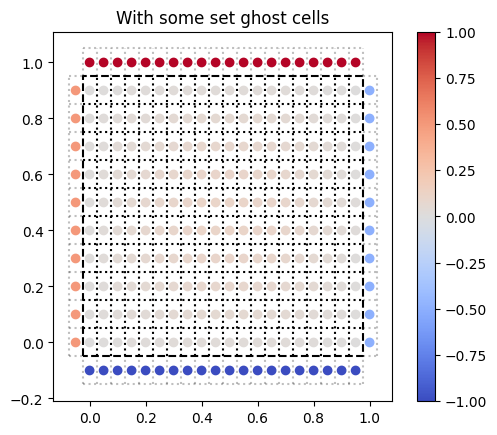

Evolving system with these boundary conditions:


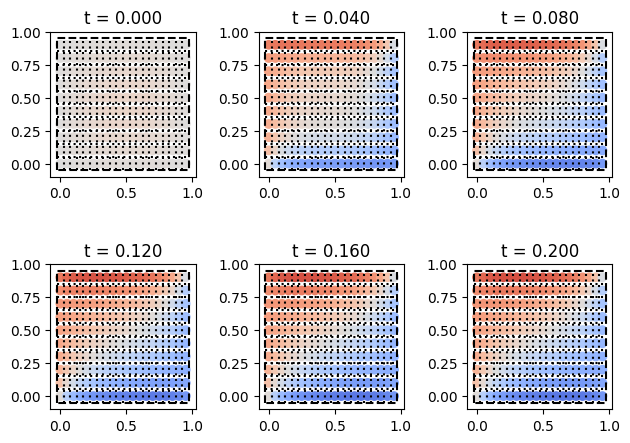

In [23]:
print(f"domain.field.shape: {domain.field.shape}")
print(f"domain._field.shape: {domain._field.shape}")

domain.get_edge_exterior(Side.BOTTOM)[:] = -1
domain.get_edge_exterior(Side.RIGHT)[:] = -0.5
domain.get_edge_exterior(Side.LEFT)[:] = 0.5
domain.get_edge_exterior(Side.TOP)[:] = 1
plot_dense_domain(domain, include_ghost_cells=True, vmin=-1, vmax=1)
plt.title("With some set ghost cells")
plt.colorbar()
plt.show()

print("Evolving system with these boundary conditions:")

fig, axs = plt.subplots(nrows=2, ncols=3)
t = 0
for ax in axs.flatten():
    # -=-   plot   -=-
    plt.sca(ax)
    plot_dense_domain(domain, vmin=-1, vmax=1, include_ghost_cells=False)
    plt.title(f"t = {t:.3f}")
    # -=- end plot -=-

    for _ in range(40):
        # -=-   update   -=-
        t += domain.parameters.dt
        domain.step()
        # -=- end update -=-

fig.tight_layout()
plt.show()